# Matplotlib and pylab inline

In [36]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Import libraries and set rcParams

In [44]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import cv2 as cv
from numpy.random import choice
import os
from src.data.filepaths import *
import numpy as np

rcParams['figure.dpi'] = 150
rcParams['figure.figsize'] = (4, 5)
rcParams['image.cmap'] = 'gray'

# For the first time make fingeprint image read function

In [38]:
# Images types 
TYPES = ['.jpg', '.jpeg', '.jpe',
         '.png', 
         '.bmp', '.dib',
         '.pbm', '.pgm', '.ppm',
         '.sr', '.ras',
         '.tiff', '.tif']

# Function for checking image type
def check_im_type(name: str):
    """
    check_im_type(name: str) -> bool
    """
    fl = False
    for tp in TYPES:
        if name.endswith(tp):
            fl = True
            break
    return fl

# function for getting 
def images_dir_list(listdir):
    return [name for name in listdir if check_im_type(name)]

# Read random function for images
def read_random_image(file_path, with_path=False, flag=cv.IMREAD_GRAYSCALE):
    '''
    read_random_image(file_path, [with_path=False, [flag=cv.IMREAD_GRAYSCALE)
    file_path - file, where images are stored
    with_path - if True return image's filepath and image
    flag - constant values from cv.imread(). Default cv.IMREAD_GREAYSCALE
    '''
    
    images_list = images_dir_list(os.listdir(file_path))
    image_name = choice(images_list)
    image_path = file_path + image_name
    
    if with_path:
        return image_path, cv.imread(image_path, flag)
    else:
        return cv.imread(image_path, flag)

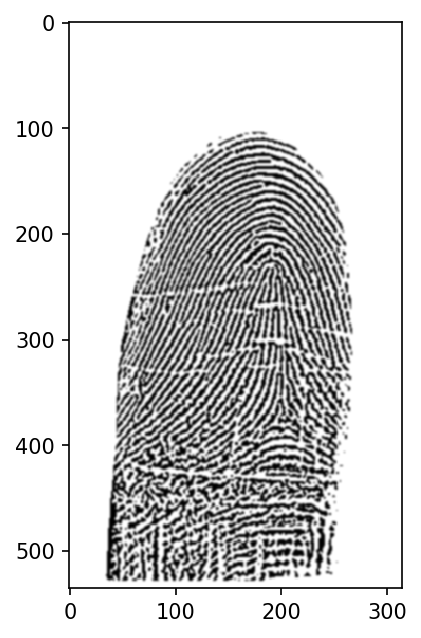

In [41]:
im = read_random_image(RAW_FILE_PATH_GOODIM)
plt.imshow(im)
plt.show()

# Make inverse color function

In [49]:
def invers_color(image):
    if image.mean() > 127.5:
        inv_image = cv.bitwise_not(image)
    else:
        inv_image = image.copy() 
        
    return inv_image

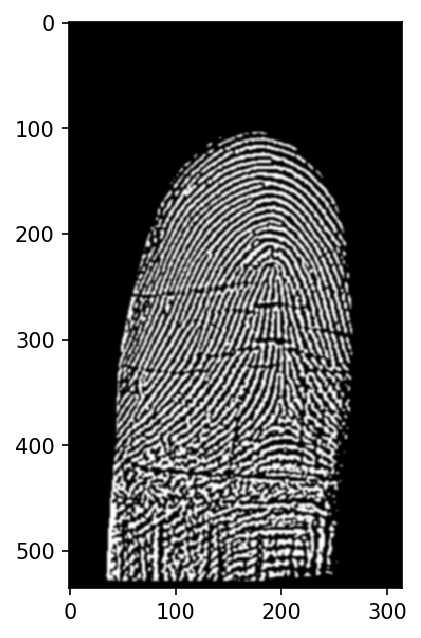

In [50]:
fp_image = invers_color(im)
plt.imshow(fp_image);

# Make function for getting fingerprint image

## Let's show process of cropping fingerprint image

In [43]:
_, contours, hierarchy = cv.findContours(fp_image, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

print("Количество контуров:", len(contours))

Количество контуров: 4


In [45]:
%time

new_contour = np.vstack(contours)
print("\nКоличество точек:", new_contour.shape[0])

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs

Количество точек: 536


## Getting a convex hull

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs

 (536, 315) (33, 103) (270, 531)


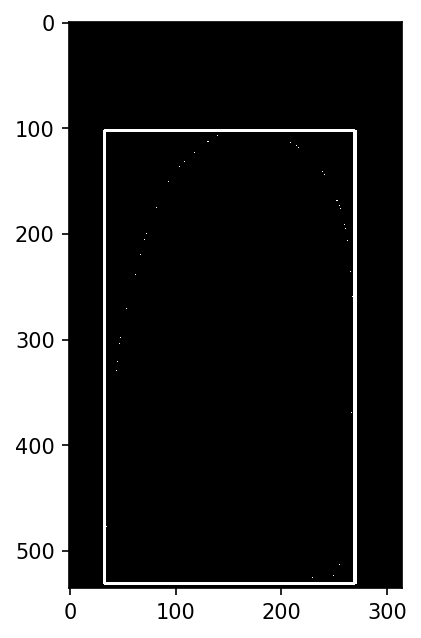

In [46]:
%time

hull = cv.convexHull(new_contour)
BOUND_CONST = 0

x1, y1, width, height = cv.boundingRect(hull)
x2, y2 = x1 + width + BOUND_CONST, y1 + height + BOUND_CONST
x1, y1 = x1 - BOUND_CONST, y1 - BOUND_CONST

if x1 < 0:
    x1 = 0
    
if y1 < 0:
    y1 = 0

if x2 > fp_image.shape[1]:
    x2 = fp_image.shape[1]
    
if y2 > fp_image.shape[0]:
    y2 = fp_image.shape[0]

print('\n',fp_image.shape, (x1, y1), (x2, y2))

mask = np.zeros(fp_image.shape)
mask = cv.rectangle(mask, (x1, y1), (x2, y2), 255, 2)

plt.imshow(cv.drawContours(mask, hull, -1, 255), cmap=plt.cm.gray);

# Getting a fingerprint image

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


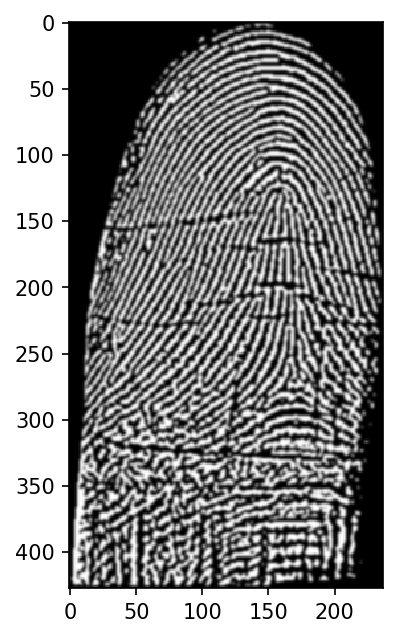

In [47]:
%time

new_image = fp_image[y1:y2, x1:x2]
plt.imshow(new_image, cmap=plt.cm.gray);

# Make function for crop fingerprint image

In [51]:
def crop_fp_image(fp_image, bound_const=0):
    """    
    crop_fp_image(fp_image[, bound_const=5]) -> resized_image
    
    crop the fingerprint image from the original image
    
    fp_image - fingerptint image
    bound_const - width of border (default: bound_const=5)
    
    resized_image - image with fingerprint only
    """
    
    # invert colors (black -> white, white -> black)
    # and binarize image

    temp_image = fp_image
    
    # get contours and unite contours
    _1, contours, _2 = cv.findContours(image=temp_image, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_SIMPLE)
    new_contour = np.vstack(contours) 

    # find parameters of bounding rectangle
    x1, y1, width, height = cv.boundingRect(new_contour)
    x2, y2 = x1 + width + bound_const, y1 + height + bound_const
    x1, y1 = x1 - bound_const, y1 - bound_const
    
    # check coordinates of rectangle
    if x1 < 0:
        x1 = 0

    if y1 < 0:
        y1 = 0

    if x2 > temp_image.shape[1]:
        x2 = temp_image.shape[1]

    if y2 > temp_image.shape[0]:
        y2 = temp_image.shape[0]
    
    # make new image
    resized_image = temp_image[y1:y2, x1:x2]
    return resized_image

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


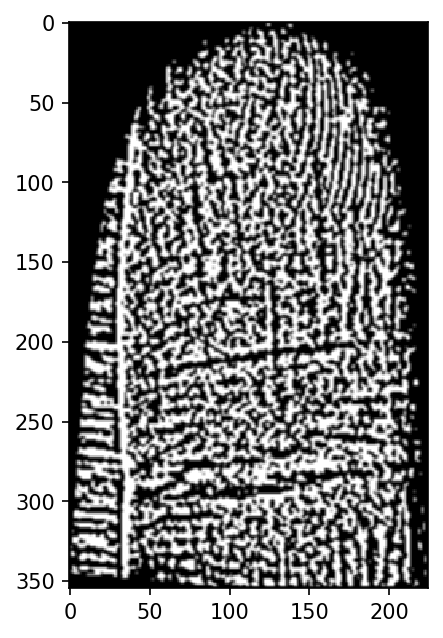

In [52]:
%time

im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
inv_image = invers_color(im)
crop_image = crop_fp_image(inv_image)

plt.imshow(crop_image)
plt.show()